In [9]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

In [11]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

In [15]:
# url = 'https://raw.githubusercontent.com/MachineLearnia/Python-Machine-Learning/master/Dataset/dataset.csv'
# data = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1")
full_path_directory = os.path.realpath(os.path.dirname('__file__'))
csv_name = r'data/data_v1.0.csv' 

In [17]:
data = pd.read_csv(os.path.join(full_path_directory, csv_name))
data.head()

Unnamed: 0  index        date cheveux   age   exp  salaire sexe  diplome  \
0           0      0  2012-06-02    roux  25.0   9.0  26803.0    F  licence   
1           1      1  2011-04-21   blond  35.0  13.0  38166.0    M  licence   
2           2      2  2012-09-07   blond  29.0  13.0  35207.0    M  licence   
3           3      3  2011-07-01    brun   NaN  12.0  32442.0    M  licence   
4           4      4  2012-08-07    roux  35.0   6.0  28533.0    F  licence   

  specialite   note dispo  embauche  
0   geologie  97.08   non         0  
1     forage  63.86   non         0  
2   geologie  78.50   non         0  
3   geologie  45.09   non         0  
4  detective  81.91   non         0

# 1. Exploratory Data Analysis

## Objectif :
- Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arriere)
- Développer une premiere stratégie de modélisation 

## Checklist de base
#### Analyse de Forme :
- **variable target** : embauche
- **lignes et colonnes** : 20000, 13
- **types de variables** : qualitatives : 4, quantitatives : 9
- **Analyse des valeurs manquantes** :
    - pas beaucoup de NaN (mais presque toutes les featurs posèdent 5% de NaN en moyenne)
    - quelques featurs qui pourai avoir des lien entre eux
    (date, age), (speciatite, salaire, exp), (sexe, cheuveux), (diplome, note)

#### Analyse de Fond :
- **Visualisation de la target** :
    - 99% positifs et 11% négatifs (On peut affirmer que nos classes ne sont pas équilibrées pour ce problème. Il faudra surement utiliser une metrique comme : le score fin ou la sensibilité ou  la précision)
    - 10% de positifs (558 / 5000)
    
    
    
- **Signification des variables** :
    - variables continues : distribution normal, non standardisées (écart type != 1 et moyenne != 0 pour touts les featurs), symétriques.
    - age : difficile d'interpreter ce graphique, clairement ces données ont été traitées, on pourrait penser 0-5, mais cela pourrait aussi etre une transformation mathématique. On peut pas savoir car la personne qui a mit ce dataset ne le précise nul part. Mais ca n'est pas tres important
    - variable qualitative : binaire (0, 1)/ multi-classe, viral
        => sexe : binaire (0, 1), 60% hommes et 40% femmes 
        => diplome : molti-classe (bac, license, master et doctorat)
                     beaucoup plus de candidats license et master et moins un peut moins bac et doctorat
        => sidpo : binaire (0, 1), 60% non disponibles, 40% disponibles
        => specialite : multi-classe, 50% geologie, 30% forage , 20% detective, 10% archeologie.



- **Relation Variables / Target** :
    - target / blood : les taux de Monocytes, Platelets, Leukocytes semblent liés au covid-19 -> hypothese a tester
    - target/age : les individus de faible age sont tres peu contaminés ? -> attention on ne connait pas l'age, et on ne sait pas de quand date le dataset (s'il s'agit des enfants on sait que les enfants sont touchés autant que les adultes). En revanche cette variable pourra etre intéressante pour la comparer avec les résultats de tests sanguins
    - target / viral : les doubles maladies sont tres rares. Rhinovirus/Enterovirus positif - covid-19 négatif ? -> hypothese a tester ? mais il est possible que la région est subie une épidémie de ce virus. De plus on peut tres bien avoir 2 virus en meme temps. Tout ca n'a aucun lien avec le covid-19
    
    
    
## Analyse plus détaillée

- **Relation Variables / Variables** :
    - blood_data / blood_data : certaines variables sont tres corrélées : +0.9 (a suveiller plus tard)
    - blood_data / age : tres faible corrélation entre age et taux sanguins
    - viral / viral : influenza rapid test donne de mauvais résultats, il fauda peut-etre la laisser tomber
    - relation maladie / blood data : Les taux sanguins entre malades et covid-19 sont différents
    - relation hospitalisation / est malade : 
    - relation hospitalisation / blood : intéressant dans le cas ou on voudrait prédire dans quelle service un patient devrait aller


- **NaN analyse** : viral : 1350(92/8), blood : 600(87/13), both : 90

### hypotheses nulle (H0): 

- Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement différents
    - H0 = Les taux moyens sont ÉGAUX chez les individus positifs et négatifs

- Les individus atteints d'une quelconque maladie ont des taux significativement différents


    

### Analyse de la forme des données

In [68]:
df = data.copy()

In [69]:
df.shape

(20000, 13)

In [70]:
# df.dtypes.value_counts().plot.pie()
df.dtypes.value_counts()

object     6
float64    4
int64      3
dtype: int64

<AxesSubplot: >

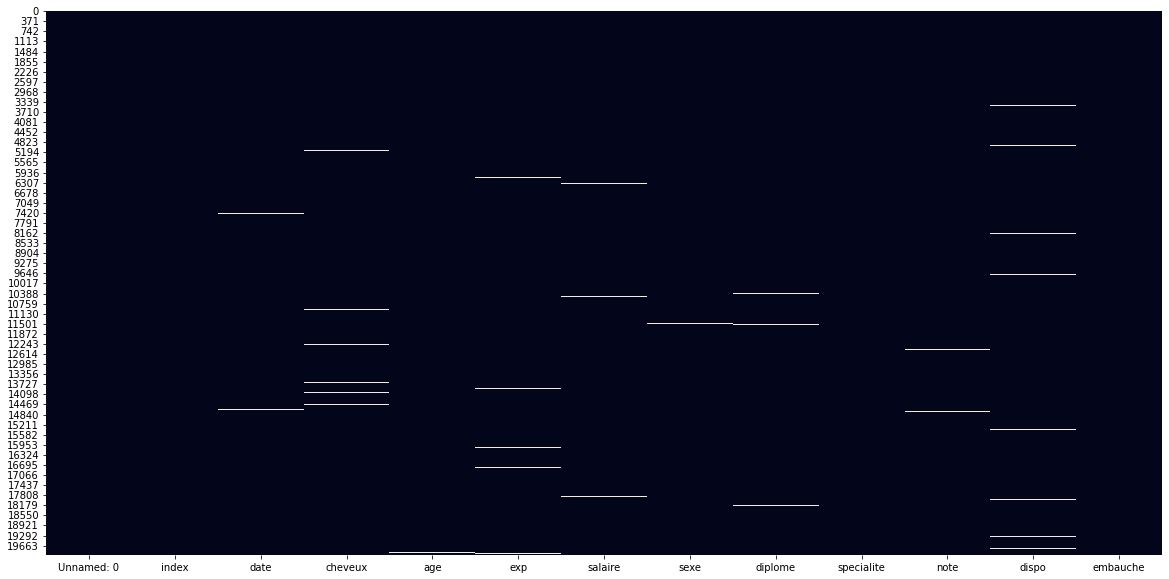

In [71]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isna(), cbar=False)

In [72]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

Unnamed: 0    0.00000
index         0.00000
embauche      0.00000
date          0.00455
age           0.00455
specialite    0.00465
salaire       0.00475
exp           0.00480
sexe          0.00500
cheveux       0.00515
dispo         0.00530
diplome       0.00550
note          0.00570
dtype: float64

## Analyse du Fond
### 1. Visulation initiale - Elimination des colonnes inutiles

In [73]:

# df = df[df.columns[df.isna().sum()/df.shape[0] < 0.9]]
# df.head()

In [74]:
# plt.figure(figsize=(20, 10))
# sns.heatmap(df.isna(), cbar=False)

In [75]:
df = df.drop(['cheveux', 'date', 'Unnamed: 0', 'index'], axis=1)

In [76]:
df.head()

age   exp  salaire sexe  diplome specialite   note dispo  embauche
0  25.0   9.0  26803.0    F  licence   geologie  97.08   non         0
1  35.0  13.0  38166.0    M  licence     forage  63.86   non         0
2  29.0  13.0  35207.0    M  licence   geologie  78.50   non         0
3   NaN  12.0  32442.0    M  licence   geologie  45.09   non         0
4  35.0   6.0  28533.0    F  licence  detective  81.91   non         0

### Examen de la colonne target

In [77]:
df['embauche'].value_counts(normalize=True)

0    0.8854
1    0.1146
Name: embauche, dtype: float64

### histogrames des variables continues 

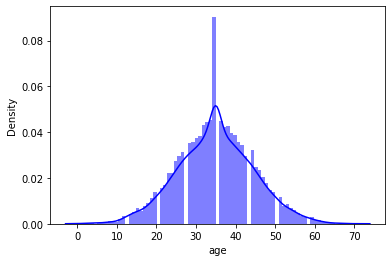

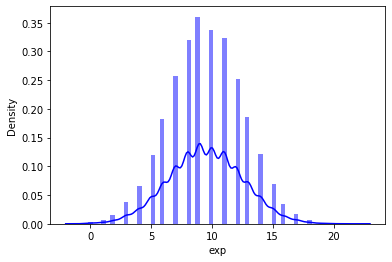

In [78]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.histplot(df[col], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)

<AxesSubplot: xlabel='age', ylabel='Density'>

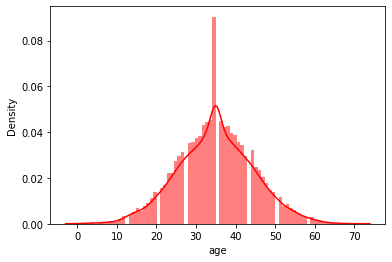

In [79]:
sns.histplot(df['age'], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)

In [80]:
df['age'].value_counts()

 35.0    1593
 34.0     797
 36.0     792
 33.0     786
 32.0     762
 38.0     752
 37.0     748
 39.0     701
 40.0     684
 31.0     678
 30.0     662
 41.0     626
 29.0     626
 28.0     619
 42.0     610
 44.0     568
 27.0     556
 26.0     525
 43.0     520
 25.0     483
 45.0     437
 46.0     417
 24.0     394
 23.0     394
 47.0     363
 48.0     314
 22.0     300
 21.0     274
 49.0     259
 20.0     248
 50.0     248
 51.0     206
 19.0     199
 18.0     159
 53.0     156
 17.0     138
 52.0     138
 54.0     124
 15.0     122
 55.0     104
 16.0      99
 14.0      92
 56.0      86
 13.0      72
 57.0      61
 12.0      58
 58.0      56
 59.0      51
 11.0      37
 61.0      29
 60.0      28
 8.0       20
 10.0      17
 62.0      17
 9.0       15
 63.0      12
 6.0        9
 7.0        8
 5.0        8
 67.0       8
 64.0       7
 65.0       7
 3.0        6
 2.0        6
 4.0        3
 72.0       2
 66.0       2
 71.0       2
 0.0        2
 69.0       1
-1.0        1
-3.0  

### Variables Qualitatives

In [81]:
for col in df.select_dtypes('object'):
    print(f'{col :-<50} {df[col].unique()}')

sexe---------------------------------------------- ['F' 'M' nan]
diplome------------------------------------------- ['licence' 'master' 'doctorat' 'bac' nan]
specialite---------------------------------------- ['geologie' 'forage' 'detective' 'archeologie' nan]
dispo--------------------------------------------- ['non' 'oui' nan]


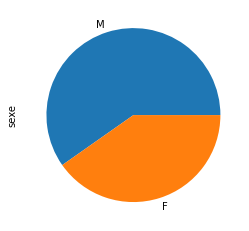

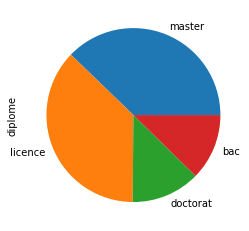

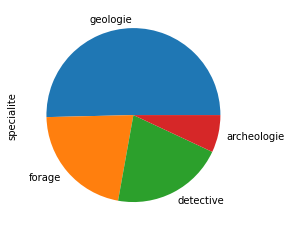

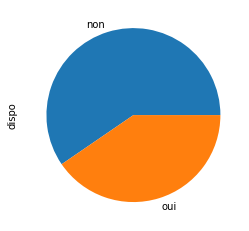

In [82]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

## Relation Target / Variables
### Création de sous-ensembles positifs et négatifs

In [83]:
positive_df = df[df['embauche'] == 1]
negative_df = df[df['embauche'] == 0]

### Création des ensembles Blood et viral

In [94]:
missing_rate = df.isna().sum()/df.shape[0]

In [95]:
# blood_columns = df.columns[(missing_rate < 0.9) & (missing_rate > 0.88)]
# blood_columns = df.columns[(missing_rate < 0.9)]
# blood_columns

Index(['age', 'exp', 'salaire', 'sexe', 'diplome', 'specialite', 'note',
       'dispo', 'embauche'],
      dtype='object')

In [65]:
# viral_columns = df.columns[(missing_rate < 0.88) & (missing_rate > 0.75)]

## Target / Blood

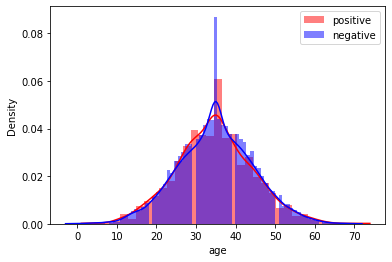

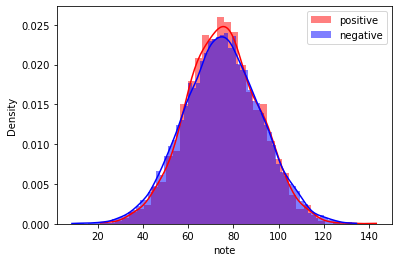

In [98]:
# for col in blood_columns:
#     plt.figure()
#     sns.distplot(positive_df[col], label='positive')
#     sns.distplot(negative_df[col], label='negative')
#     plt.legend()

for col in df.columns.drop(['embauche', 'sexe', 'diplome', 'specialite', 'dispo']):
    plt.figure()
    sns.histplot(positive_df[col], color="red", label="positive", kde=True, stat="density", linewidth=0)
    sns.histplot(negative_df[col], color="blue", label="negative", kde=True, stat="density", linewidth=0)
    plt.legend()

### Relation Target / age

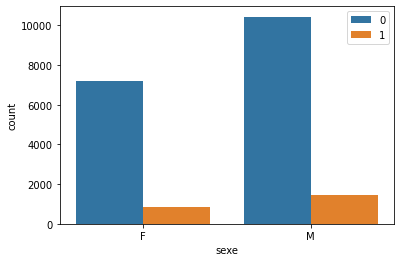

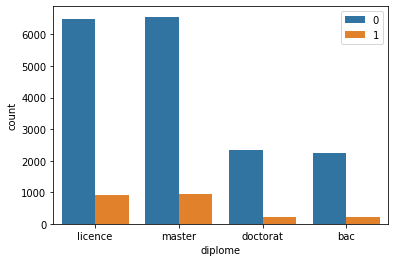

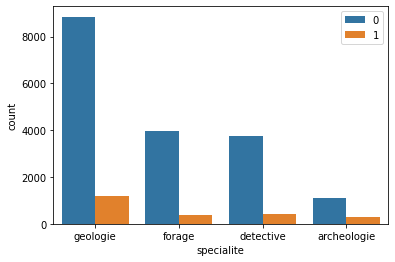

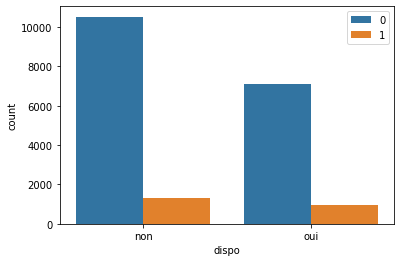

In [100]:
for col in df.columns.drop(['note', 'salaire', 'exp', 'age']):
    plt.figure()
    # sns.histplot(positive_df[col], color="red", label="positive", kde=True, stat="density", linewidth=0)
    # sns.histplot(negative_df[col], color="blue", label="negative", kde=True, stat="density", linewidth=0)
    sns.countplot(x=col, hue='embauche', data=df)
    plt.legend()

### Relation Target / Viral

In [ ]:
pd.crosstab(df['SARS-Cov-2 exam result'], df['Influenza A'])

Influenza A             detected  not_detected
SARS-Cov-2 exam result                        
negative                      18          1224
positive                       0           112

In [101]:
# for col in viral_columns:
#     plt.figure()
#     sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'], df[col]), annot=True, fmt='d')

for col in df.columns.drop(['note', 'salaire', 'exp', 'age']):
    plt.figure()
    sns.heatmap(pd.crosstab(df['embauche'], df[col]), annot=True, fmt='d')
    

## Analyse un peu plus Avancée
### Relation Variables / Variables
### relations Taux Sanguin

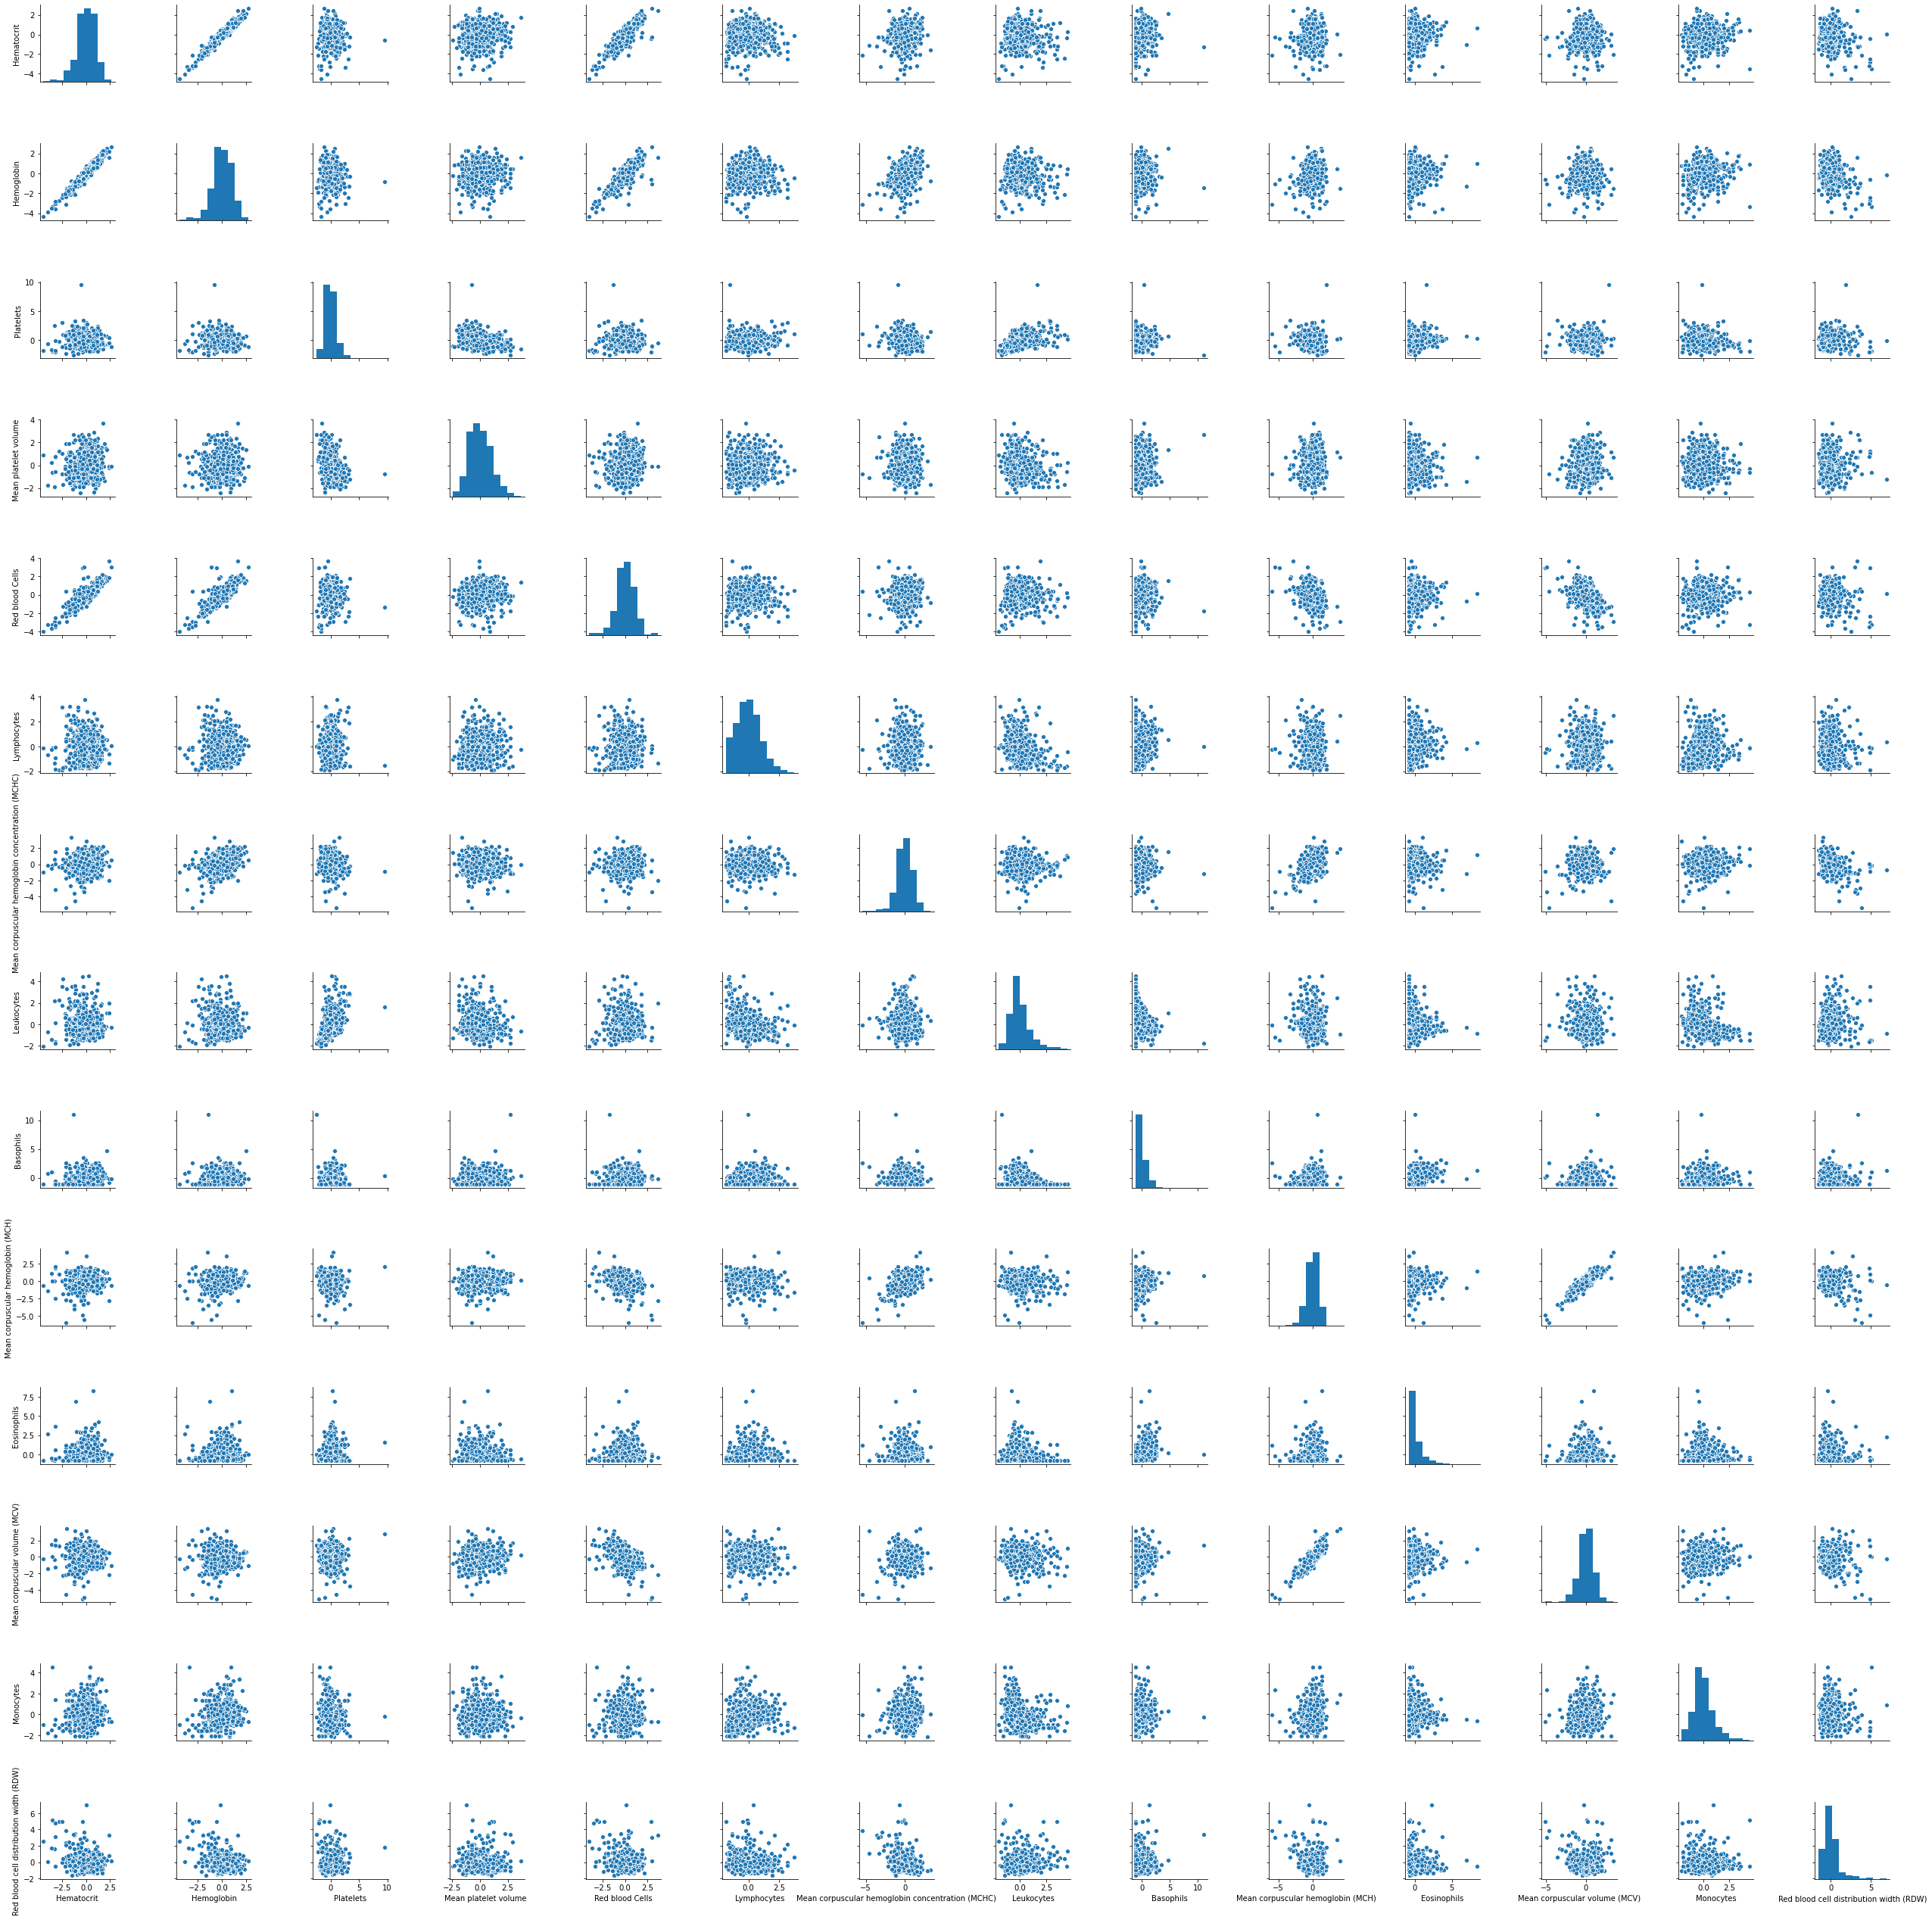

In [ ]:
sns.pairplot(df[blood_columns])

In [ ]:
sns.clustermap(df[blood_columns].corr())

## Relation Age / Sang

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this wa

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

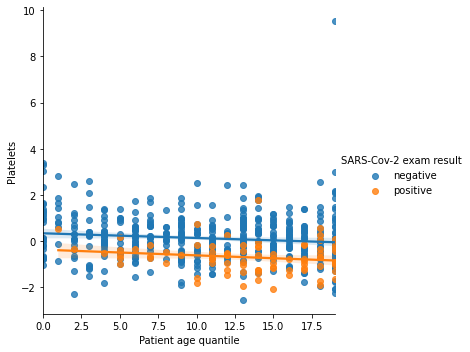

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

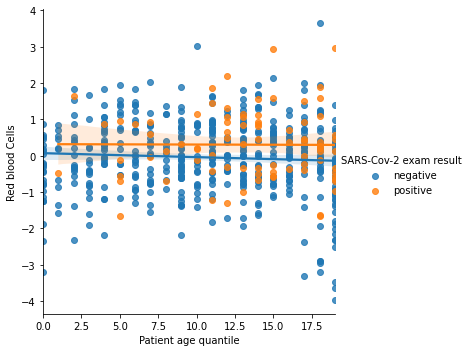

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

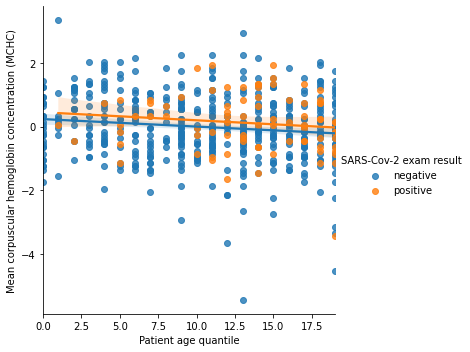

<Figure size 432x288 with 0 Axes>

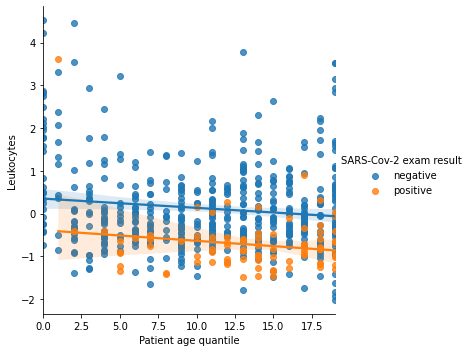

<Figure size 432x288 with 0 Axes>

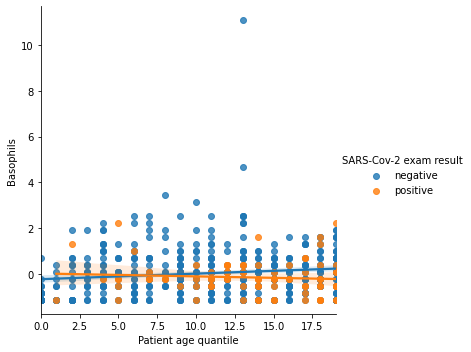

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

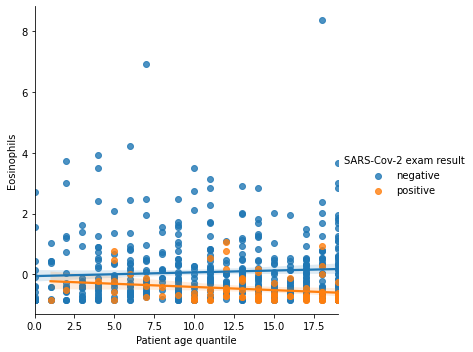

<Figure size 432x288 with 0 Axes>

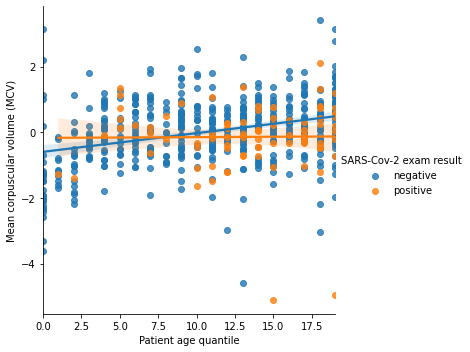

<Figure size 432x288 with 0 Axes>

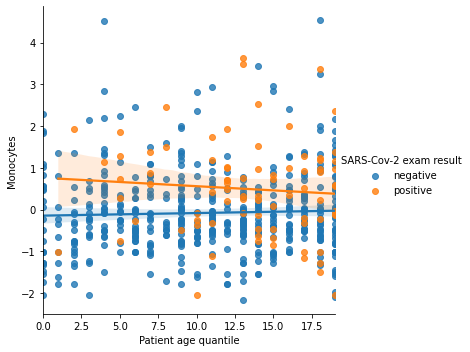

<Figure size 432x288 with 0 Axes>

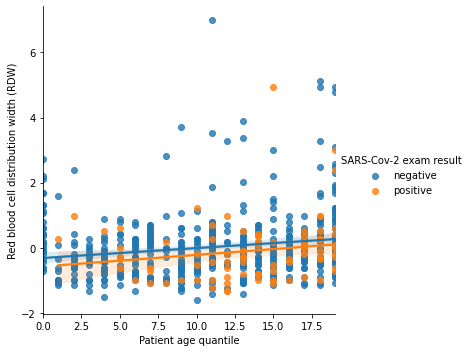

In [ ]:
for col in blood_columns:
    plt.figure()
    sns.lmplot(x='Patient age quantile', y=col, hue='SARS-Cov-2 exam result', data=df)

In [ ]:
df.corr()['Patient age quantile'].sort_values()

Leukocytes                                              -0.166386
Platelets                                               -0.158683
Lymphocytes                                             -0.125935
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Red blood Cells                                         -0.037510
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Eosinophils                                              0.022085
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Monocytes                                                0.050962
Hemoglobin                                               0.060320
Hematocrit                                               0.096808
Basophils                                                0.107525
Mean platelet volume                                     0.119449
Red blood cell distribution width (RDW)                  0.166429
Mean corpu

### Relation entre Influenza et rapid test

In [ ]:
pd.crosstab(df['Influenza A'], df['Influenza A, rapid test'])

Influenza A, rapid test  negative  positive
Influenza A                                
detected                        2         4
not_detected                  245        15

In [ ]:
pd.crosstab(df['Influenza B'], df['Influenza B, rapid test'])

Influenza B, rapid test  negative  positive
Influenza B                                
detected                       18        11
not_detected                  233         4

### relation Viral / sanguin 
#### Création d'une nouvelle variable "est malade"

In [ ]:
df['est malade'] = np.sum(df[viral_columns[:-2]] == 'detected', axis=1) >=1

In [ ]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


In [ ]:
malade_df = df[df['est malade'] == True]
non_malade_df = df[df['est malade'] == False]

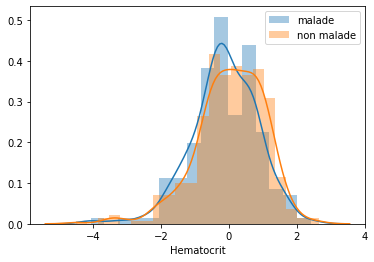

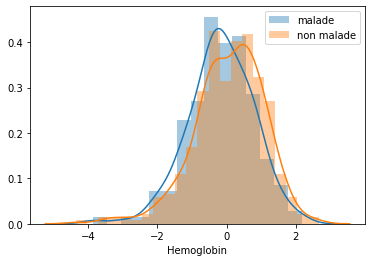

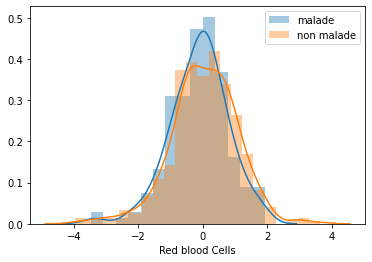

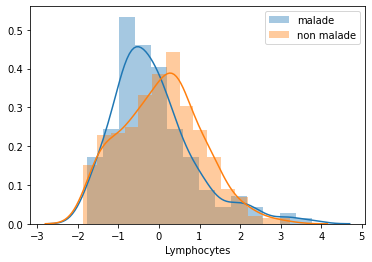

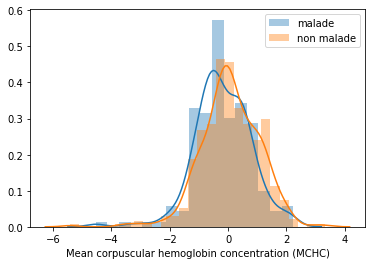

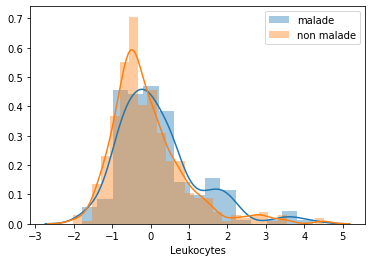

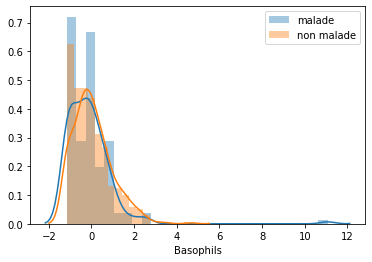

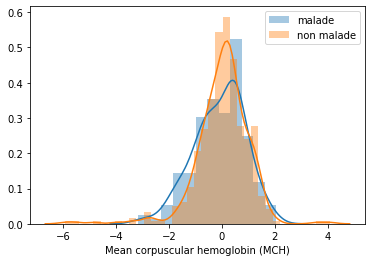

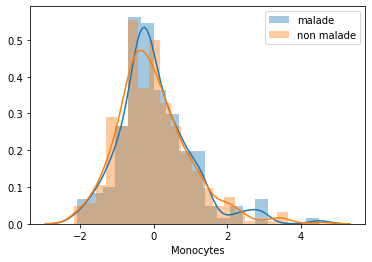

In [ ]:
for col in blood_columns:
    plt.figure()
    sns.distplot(malade_df[col], label='malade')
    sns.distplot(non_malade_df[col], label='non malade')
    plt.legend()

In [ ]:
def hospitalisation(df):
    if df['Patient addmited to regular ward (1=yes, 0=no)'] == 1:
        return 'surveillance'
    elif df['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1:
        return 'soins semi-intensives'
    elif df['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1:
        return 'soins intensifs'
    else:
        return 'inconnu'

In [ ]:
df['statut'] = df.apply(hospitalisation, axis=1)

In [ ]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


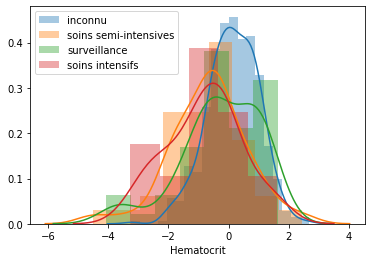

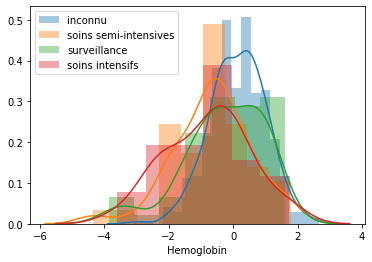

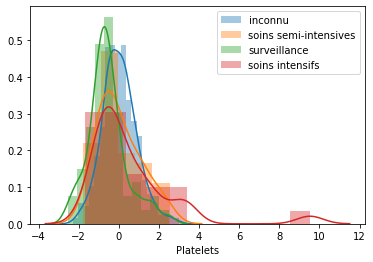

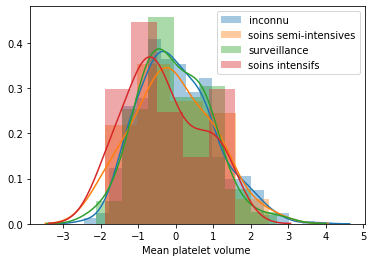

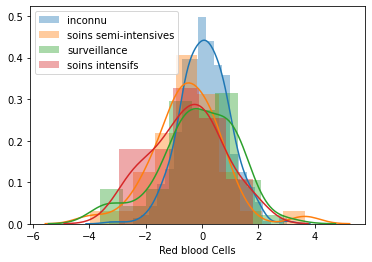

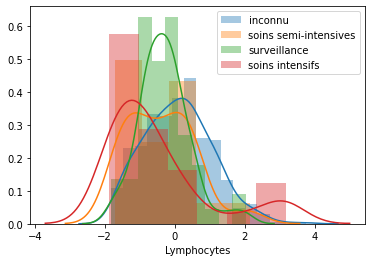

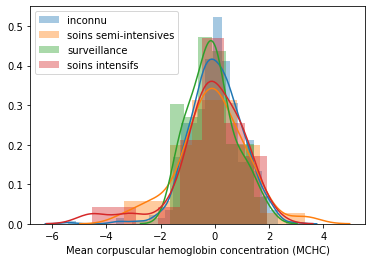

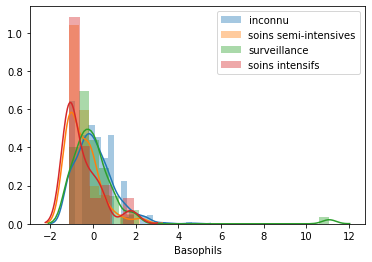

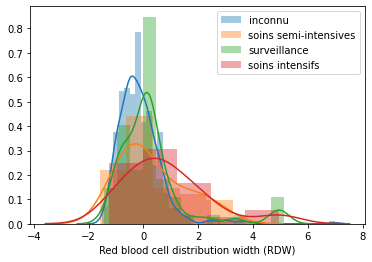

In [ ]:
for col in blood_columns:
    plt.figure()
    for cat in df['statut'].unique():
        sns.distplot(df[df['statut']==cat][col], label=cat)
    plt.legend()

In [ ]:
df[blood_columns].count()

Hematocrit                                          603
Hemoglobin                                          603
Platelets                                           602
Mean platelet volume                                599
Red blood Cells                                     602
Lymphocytes                                         602
Mean corpuscular hemoglobin concentration (MCHC)    602
Leukocytes                                          602
Basophils                                           602
Mean corpuscular hemoglobin (MCH)                   602
Eosinophils                                         602
Mean corpuscular volume (MCV)                       602
Monocytes                                           601
Red blood cell distribution width (RDW)             602
dtype: int64

In [ ]:
df[viral_columns].count()

Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
Parainfluenza 2                1352
Influenza B, rapid test         820
Influenza A, rapid test         820
dtype: int64

In [ ]:
df1 = df[viral_columns[:-2]]
df1['covid'] = df['SARS-Cov-2 exam result']
df1.dropna()['covid'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


negative    0.91716
positive    0.08284
Name: covid, dtype: float64

In [ ]:
df2 = df[blood_columns]
df2['covid'] = df['SARS-Cov-2 exam result']
df2.dropna()['covid'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


negative    0.864548
positive    0.135452
Name: covid, dtype: float64

## T-Test

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
positive_df

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
78511c183ae18bc                     7               positive   
d7834ed75f2da44                    16               positive   
b16b49f7bd3e692                    10               positive   
4382f5ea05e60c4                     2               positive   
d3729cd2658ca64                    15               positive   
...                               ...                    ...   
5c386388ba3c3f0                    16               positive   
9f8dfe2ae239238                     4               positive   
db77903261ab6d0                    15               positive   
ae66feb9e4dc3a0                     3               positive   
2697fdccbfeb7f7                    19               positive   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
78511c183ae18bc                                               0   
d7834ed75f2da44                                               1   
b16b49f7bd3e692                                               0   
4382f5ea05e60c4                                               0   
d3729cd2658ca64                                               0   
...                                                         ...   
5c386388ba3c3f0                                               0   
9f8dfe2ae239238                                               0   
db77903261ab6d0                                               0   
ae66feb9e4dc3a0                                               0   
2697fdccbfeb7f7                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
78511c183ae18bc                                                  0       
d7834ed75f2da44                                                  0       
b16b49f7bd3e692                                                  0       
4382f5ea05e60c4                                                  0       
d3729cd2658ca64                                                  0       
...                                                            ...       
5c386388ba3c3f0                                                  0       
9f8dfe2ae239238                                                  0       
db77903261ab6d0                                                  0       
ae66feb9e4dc3a0                                                  0       
2697fdccbfeb7f7                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
78511c183ae18bc                                                  0       
d7834ed75f2da44                                                  0       
b16b49f7bd3e692                                                  0       
4382f5ea05e60c4                                                  0       
d3729cd2658ca64                                                  0       
...                                                            ...       
5c386388ba3c3f0                                                  0       
9f8dfe2ae239238                                                  0       
db77903261ab6d0                                                  0       
ae66feb9e4dc3a0                                                  0       
2697fdccbfeb7f7                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
78511c183ae18bc         NaN         NaN        NaN                    NaN   
d7834ed75f2da44         NaN         NaN        NaN                    NaN   
b16b49f7bd3e692         NaN         NaN        NaN                    NaN   
4

In [ ]:
balanced_neg = negative_df.sample(positive_df.shape[0])

In [ ]:
def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(balanced_neg[col].dropna(), positive_df[col].dropna())
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 0

In [ ]:
for col in blood_columns:
    print(f'{col :-<50} {t_test(col)}')

Hematocrit---------------------------------------- 0
Hemoglobin---------------------------------------- H0 Rejetée
Platelets----------------------------------------- H0 Rejetée
Mean platelet volume ----------------------------- 0
Red blood Cells----------------------------------- 0
Lymphocytes--------------------------------------- 0
Mean corpuscular hemoglobin concentration (MCHC)-- 0
Leukocytes---------------------------------------- H0 Rejetée
Basophils----------------------------------------- 0
Mean corpuscular hemoglobin (MCH)----------------- 0
Eosinophils--------------------------------------- H0 Rejetée
Mean corpuscular volume (MCV)--------------------- 0
Monocytes----------------------------------------- H0 Rejetée
Red blood cell distribution width (RDW)----------- 0
